In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn import linear_model as linMod
import toolbox as tb;
import kaggleData as kD;

We generate toydata

In [2]:
#toydata shall have n vectors with 5 dimensions
n = 100000
#probability for signal-label
s_prob = 0.05
dim = 4
data = tb.createToyData(n,dim,s_prob)
weights = data[:,0]
labels = data[:,1]
x_1 = data[:,2]
x_2 = data[:,3]

visualize

Populating the interactive namespace from numpy and matplotlib


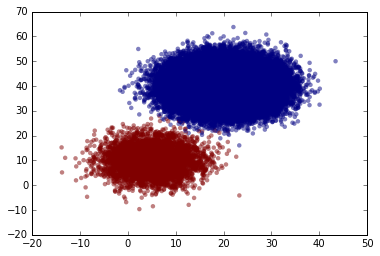

In [3]:
%pylab inline
plt.scatter(x_1, x_2, edgecolor="", c=labels, alpha=0.5)

split toydata into training- and testset for the classifier

In [4]:
n_train = int(n/10)

train_x_1,test_x_1 = tb.splitList(x_1,n_train)
train_x_2,test_x_2 = tb.splitList(x_2,n_train)
train_labels,test_labels = tb.splitList(labels,n_train)
test_weights = tb.splitList(weights,n_train)[1]

For Comparison, we calculate the best possible AMS    
(case: every signal correctly detected)

In [5]:
tb.calcMaxAMS(test_weights,test_labels);

Found 4666 signals.
Weightsums signal: 117.065917471 | background: 0
Maximum AMS possible with this Data: 20.295369237859575


we initialize the Logistic Regression Classifier, shape the input-data and fit the model

In [6]:
logReg = linMod.LogisticRegression(C=1e5)

train_x = np.array([train_x_1,train_x_2]).transpose()
test_x = np.array([test_x_1,test_x_2]).transpose()
train_labels = np.array(train_labels).transpose()
test_labels = np.array(test_labels).transpose()

logReg.fit(train_x,train_labels)

logReg.sparsify()

predProb = logReg.predict_proba(test_x)
pred = logReg.predict(test_x)
score = logReg.score(test_x,test_labels)

print("Score:", score)

Score: 0.999822222222


In [7]:
s,b = tb.calcWeightSums(test_weights,pred,test_labels)
print("AMS:",tb.calcAMS(s,b))

AMS: 18.312613892950132


We successfully tested logistic Regression, now let's use it on actual CERN-Data.           

In [8]:
(header,
 test_data,
 test_weights,
 test_labels,
 train_data,
 train_weights,
 train_labels) = kD.getWholeDataSet(kSet="v")

Trainingset has key "t"                   
Public Testset has key "b"   
Private Testset has key "v"

In [9]:
train_eventList,test_eventList = kD.getFeatureSets("EventId",header,test_data,train_data)

How are labels and weights related?

In [10]:
signal_sum = int(test_labels.cumsum()[-1])
background_sum = int(len(test_labels)-signal_sum)
signal_weight = 0
background_weight = 0
for i in range(0,len(test_labels)):
    if test_labels[i] > 0:
        signal_weight += test_weights[i]
    else:
        background_weight += test_weights[i]
print("Mean of background-weights:", background_weight/background_sum)
print("Mean of signal-weights:",signal_weight/signal_sum)

Mean of background-weights: 1.38702756616
Mean of signal-weights: 0.00450270106462


We observe that False signals are weighted a lot heavier than True signals. 

If a classifier achieved a higher AMS while detecting less signals,   
we can make statements about the usabilty of the features, the classifier used.

We choose features with beneficial properties for classifying.

In [11]:
(train_DER_met_phi_centrality,
 test_DER_met_phi_centrality) = kD.getFeatureSets("DER_met_phi_centrality",header,test_data,train_data)
(train_DER_pt_ratio_lep_tau,
 test_DER_pt_ratio_lep_tau) = kD.getFeatureSets("DER_pt_ratio_lep_tau",header,test_data,train_data)

Using DER_mass_MMC was not allowed in the former contest, we use it here anyway to test our classifier

In [12]:
(train_DER_mass_MMC,
 test_DER_mass_MMC) = kD.getFeatureSets("DER_mass_MMC",header,test_data,train_data)

In [13]:
train_labels = np.array(train_labels).transpose()
test_labels = np.array(test_labels).transpose()

In [14]:
tb.calcMaxAMS(test_weights,test_labels);

Found 153683 signals.
Weightsums signal: 691.988607714 | background: 0
Maximum AMS possible with this Data: 67.71112289514157


We start with one feature and add more with every regression to see improvement of the AMS

In [15]:
def logisticReg(train_x,train_labels,test_x,test_labels):
    logReg = None
    logReg = linMod.LogisticRegression()
    logReg.fit(train_x,train_labels)
    logReg.sparsify()
    predProb = logReg.predict_proba(test_x)
    pred = logReg.predict(test_x)
    signals = int(pred.cumsum()[-1])  
    return predProb,pred

In [16]:
def logRegFor(fList):
    for feature in fList:
        print("Feature:",feature)
        trainList_x,testList_x = kD.getFeatureSets(feature)
        train_x = np.array([trainList_x]).transpose()
        test_x = np.array([testList_x]).transpose()
        logisticReg(train_x,train_labels,test_x,test_labels)[1];

In [17]:
(train_PRI_tau_pt,
 test_PRI_tau_pt) = kD.getFeatureSets("PRI_tau_pt",header,test_data,train_data)
(train_DER_met_phi_centrality,
 test_DER_met_phi_centrality) = kD.getFeatureSets("DER_met_phi_centrality",header,test_data,train_data)
(train_DER_pt_h,
 test_DER_pt_h) = kD.getFeatureSets("DER_pt_h",header,test_data,train_data)
(train_DER_pt_ratio_lep_tau,
 test_DER_pt_ratio_lep_tau) = kD.getFeatureSets("DER_pt_ratio_lep_tau",header,test_data,train_data)
(train_DER_mass_transverse_met_lep,
 test_DER_mass_transverse_met_lep) = kD.getFeatureSets("DER_mass_transverse_met_lep",header,test_data,train_data)

We are able to achieve a higher AMS by adjusting the decision-threshold

In [18]:
def customThreshold(predProb,t = 0.5):
    newPred = np.zeros(len(predProb))
    for i in range(0,len(predProb)):
        if predProb[i][1] > t:
            newPred[i]=1
    return newPred   

In [19]:
def bestThreshold(predProb,test_weights,test_labels):
    bestPred = predProb
    thresh = 0
    maxAMS = 0
    maxThresh = 0
    newSignals = 0
    for thresh in np.linspace(1.0,0.0,100):
        newPred = customThreshold(predProb,thresh)
        s,b = tb.calcWeightSums(test_weights,newPred,test_labels)
        #print("s:",s,"b:",b)
        ams = tb.calcAMS(s,b)
        #print("ams:",ams)
        if ams > maxAMS:
            bestPred = newPred
            maxThresh = thresh
            maxAMS = ams
            newSignals = int(newPred.cumsum()[-1])
    #print("Maximum AMS:",maxAMS, "with threshold", maxThresh)
    #print("Signals read:", newSignals)
    return bestPred,maxAMS,maxThresh,newSignals

In [20]:
def compareBinaryArrays(a,b):
    if np.shape(a) != np.shape(b):
        print("ERROR: Arrays must have same shape.")
        return None
    eq_total = 0
    eq_ones = 0
    eq_zeros = 0
    for i in range(0,len(a)):
        if a[i] == b[i]:
            eq_total += 1
            if a[i] == 1:
                eq_ones += 1
            else:
                eq_zeros += 1
    return eq_total,eq_ones,eq_zeros

In [21]:
def fullEvaluation(predProb,pred,test_weights,test_labels):
    signals = pred.cumsum()[-1]
    correct = np.equal(pred,test_labels).cumsum()[-1]    
    s,b = tb.calcWeightSums(test_weights,pred,test_labels)
    ams = tb.calcAMS(s,b)
   
    newPred,maxAMS,maxThresh,newSignals = bestThreshold(predProb,test_weights,test_labels)
    newcorrect = np.equal(newPred,test_labels).cumsum()[-1]
    
    T_eq1,T_eq0 = compareBinaryArrays(test_labels,test_labels)[1:]
    o_eqt,o_eq1,o_eq0 = compareBinaryArrays(pred,test_labels)
    a_eqt,a_eq1,a_eq0 = compareBinaryArrays(newPred,test_labels)
    
    print("Signals in test-data:", test_labels.cumsum()[-1])
    print("Comparison of [o]riginal and [a]djusted predictions:\n"+
          " - [o]Signals read:", signals,"\n"+
          " - [a]Signals read:", newSignals,"\n"+
          " -- Difference:", (signals-newSignals),"\n"+
          " - [o]Correct labels:", o_eqt,"| signals:", o_eq1,"| background:",o_eq0,"\n"+
          " ----- wrong signals:", (T_eq1-o_eq1), "| background:", (T_eq0-o_eq0),"\n"+
          " - [a]Correct labels:", a_eqt,"| signals:", a_eq1,"| background:",a_eq0,"\n"+
          " ----- wrong signals:", (T_eq1-a_eq1), "| background:", (T_eq0-a_eq0),"\n"+
          " -- Difference labels:", (a_eqt-o_eqt),"| signals:", (a_eq1-o_eq1),"| background:",(a_eq0-o_eq0),"\n"+
          " - [o]AMS:", ams,"\n"+
          " - [a]AMS:", maxAMS,"(threshold =",maxThresh,")\n"+
          " -- Difference:", (ams-maxAMS),"\n"
         )
    return pred,newPred

In [22]:
train_x = np.array(
    [train_PRI_tau_pt,
     train_DER_met_phi_centrality,
     train_DER_pt_h,
     train_DER_pt_ratio_lep_tau]).transpose()
test_x = np.array(
    [test_PRI_tau_pt,
     test_DER_met_phi_centrality,
     test_DER_pt_h,
     test_DER_pt_ratio_lep_tau]).transpose()

In [23]:
logReg = linMod.LogisticRegression()
logReg.fit(train_x,train_labels)
logReg.sparsify()
predProb = logReg.predict_proba(test_x)
pred = logReg.predict(test_x)
signals = int(pred.cumsum()[-1])  

s,b = tb.calcWeightSums(test_weights,pred,test_labels)
ams = tb.calcAMS(s,b)
print("AMS:", ams)

AMS: 1.319226630790794


In [24]:
(predProb,
 pred) = logisticReg(
    train_x,
    train_labels,
    test_x,
    test_labels);
fullEvaluation(predProb,pred,test_weights,test_labels);

Signals in test-data: 153683.0
Comparison of [o]riginal and [a]djusted predictions:
 - [o]Signals read: 88315.0 
 - [a]Signals read: 270383 
 -- Difference: -182068.0 
 - [o]Correct labels: 315490 | signals: 53744 | background: 261746 
 ----- wrong signals: 99939 | background: 34571 
 - [a]Correct labels: 275176 | signals: 124621 | background: 150555 
 ----- wrong signals: 29062 | background: 145762 
 -- Difference labels: -40314 | signals: 70877 | background: -111191 
 - [o]AMS: 1.319226630790794 
 - [a]AMS: 1.416747309974929 (threshold = 0.252525252525 )
 -- Difference: -0.09752067918413498 



In [25]:
print("[o] correct signal/correct labels:",(53744/315491))
print("[o] correct background/correct labels:",(261747/315491))
print("[a] correct signal/correct labels:",(124621/275182))
print("[a] correct background/correct labels:",(150561/275182))
print("")
print("[o] wrong signal/wrong labels:",(99939/(len(test_labels)-315491)))
print("[o] wrong background/wrong labels:",(34570/(len(test_labels)-315491)))
print("[a] wrong signal/wrong labels:",(29062/(len(test_labels)-275182)))
print("[a] wrong background/wrong labels:",(145756/(len(test_labels)-275182)))

[o] correct signal/correct labels: 0.17035034279900219
[o] correct background/correct labels: 0.8296496572009978
[a] correct signal/correct labels: 0.4528675567442638
[a] correct background/correct labels: 0.5471324432557362

[o] wrong signal/wrong labels: 0.7429911753116892
[o] wrong background/wrong labels: 0.2570088246883108
[a] wrong signal/wrong labels: 0.16624146254962305
[a] wrong background/wrong labels: 0.833758537450377


By adjusting the threshold, we raise the rate of correct signals at the expense of correctly predicted background-events.
This results in a higher AMS even though we softened our decision-threshold

In [26]:
train_x = np.array(
    [train_DER_met_phi_centrality,
     train_DER_pt_ratio_lep_tau]).transpose()
test_x = np.array(
    [test_DER_met_phi_centrality,
     test_DER_pt_ratio_lep_tau]).transpose()
predProb,pred = logisticReg(
    train_x,train_labels,
    test_x,
    test_labels);
fullEvaluation(predProb,pred,test_weights,test_labels);

Signals in test-data: 153683.0
Comparison of [o]riginal and [a]djusted predictions:
 - [o]Signals read: 105544.0 
 - [a]Signals read: 266339 
 -- Difference: -160795.0 
 - [o]Correct labels: 311453 | signals: 60340 | background: 251113 
 ----- wrong signals: 93343 | background: 45204 
 - [a]Correct labels: 273908 | signals: 121965 | background: 151943 
 ----- wrong signals: 31718 | background: 144374 
 -- Difference labels: -37545 | signals: 61625 | background: -99170 
 - [o]AMS: 1.3069683870455429 
 - [a]AMS: 1.4054044012191869 (threshold = 0.262626262626 )
 -- Difference: -0.098436014173644 



In [27]:
#all but events, pls
train_x = train_data[:,1:-1]
test_x = test_data[:,1:-1]

In [28]:
predProb,pred = logisticReg(
    train_x,train_labels,
    test_x,
    test_labels)[0:2];
fullEvaluation(predProb,pred,test_weights,test_labels);

Signals in test-data: 153683.0
Comparison of [o]riginal and [a]djusted predictions:
 - [o]Signals read: 123302.0 
 - [a]Signals read: 156343 
 -- Difference: -33041.0 
 - [o]Correct labels: 337915 | signals: 82450 | background: 255465 
 ----- wrong signals: 71233 | background: 40852 
 - [a]Correct labels: 337654 | signals: 98840 | background: 238814 
 ----- wrong signals: 54843 | background: 57503 
 -- Difference labels: -261 | signals: 16390 | background: -16651 
 - [o]AMS: 2.011670365593861 
 - [a]AMS: 2.0553599333270114 (threshold = 0.434343434343 )
 -- Difference: -0.04368956773315036 



private rank #1485!

We should use more features, but also get rid of too noisy ones

In [29]:
featList = ['DER_mass_MMC','DER_mass_transverse_met_lep','DER_mass_vis']
(new_header,new_test_data,new_test_weights,new_test_labels) = kD.getCustomDataSet(featList,kSet = "v")
(new_header,new_train_data,new_train_weights,new_train_labels) = kD.getCustomDataSet(featList,kSet = "t")
predProb,pred = logisticReg(
    new_train_data,new_train_labels,
    new_test_data, new_test_labels);
fullEvaluation(predProb,pred,new_test_weights,new_test_labels);

Signals in test-data: 153683.0
Comparison of [o]riginal and [a]djusted predictions:
 - [o]Signals read: 117993.0 
 - [a]Signals read: 187104 
 -- Difference: -69111.0 
 - [o]Correct labels: 314504 | signals: 68090 | background: 246414 
 ----- wrong signals: 85593 | background: 49903 
 - [a]Correct labels: 312463 | signals: 101625 | background: 210838 
 ----- wrong signals: 52058 | background: 85479 
 -- Difference labels: -2041 | signals: 33535 | background: -35576 
 - [o]AMS: 1.6091235418331122 
 - [a]AMS: 1.771872035407086 (threshold = 0.40404040404 )
 -- Difference: -0.1627484935739738 

